# Import Necessary Libraries #
Added the following imports

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline
sns.set_style('whitegrid')

# Load and Inspect the Annotations #
## Set Paths ##
Created variables for data paths

In [13]:
raw_data_dir = "../data/raw"
processed_data_dir = "../data/processed"

train_images_dir = os.path.join(raw_data_dir, "train_v2")
test_images_dir = os.path.join(raw_data_dir, "test_v2")

annotations_path = os.path.join(raw_data_dir, "train_ship_segmentations_v2.csv")

## Read CSV ##
File must be loaded correctly and first few rows should look as expected.

In [14]:
df = pd.read_csv(annotations_path)
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Basic Info and Stats ##
If NaN values in EncodedPixels = no ships in image

In [15]:
df.info()       # Check data types and null counts
df.describe()   # Summary stats for numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


,ImageId,EncodedPixels
count,231723,81723
unique,192556,81722
top,e6fd0c12e.jpg,43801 1 44567 4 45334 5 46100 8 46867 9 47636 ...
freq,15,2


## Ship vs. No Ship Analysis ##
Grouped by ImageId to see how many ships each image has

In [16]:
grouped = df.groupby('ImageId')['EncodedPixels'].count()
print("Number of unique images:", len(grouped))
print("Images with no ships:", (grouped == 0).sum())
print("Images with >= 1 ship:", (grouped > 0).sum())

Number of unique images: 192556
Images with no ships: 150000
Images with >= 1 ship: 42556


# Visualization of a Sample Image #
## Create a Run-Length Decoding Function ##

In [19]:
def rle_decode(mask_rle, shape):
    """
    Decode a run-length encoded mask string into a binary mask array.

    Parameters:
    - mask_rle: string containing space-separated start positions and lengths.
    - shape: tuple (height, width) defining the dimensions of the image.

    Returns:
    - numpy array of shape `shape`, where 1s indicate the mask and 0s the background.
    """
    if pd.isnull(mask_rle):
        return np.zeros(shape, dtype=np.uint8)
    
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1  # Convert to zero-indexed
    ends = starts + lengths
    # Create a flat array and fill mask values
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, end in zip(starts, ends):
        img[start:end] = 1
    # Reshape the flat array to the original image dimensions.
    return img.reshape(shape).T  # Transpose to align with image orientation

## Display One Image with Its Mask ##
If images have different dimensions = function will adjust the shape parameter dynamically.

Sample Image ID: 360e6acc1.jpg


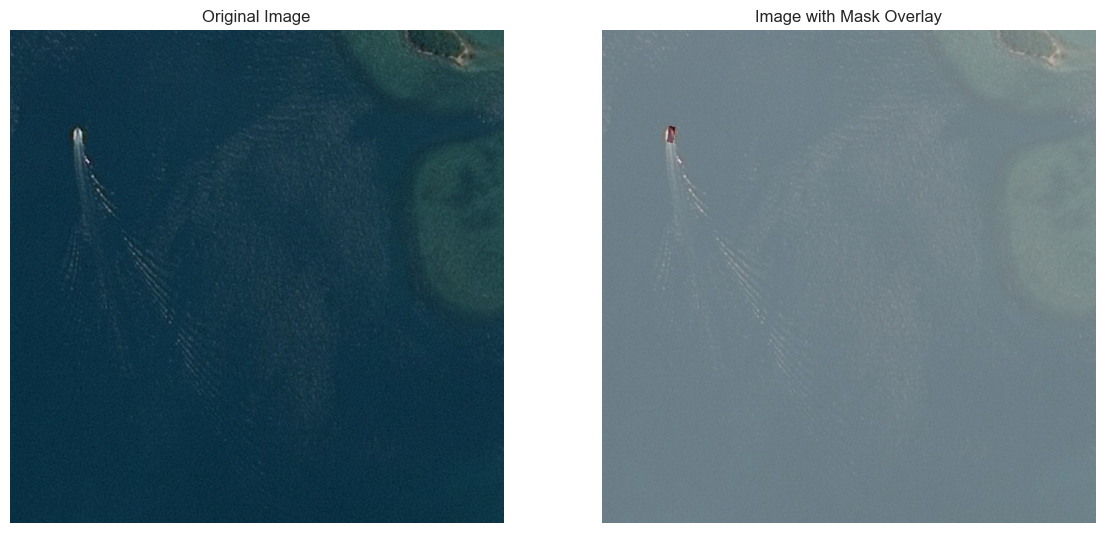

In [20]:
# Define path to the training images directory (adjust as needed)
train_images_dir = os.path.join("..", "data", "raw", "train_v2")

# Filter for images with at least one ship
images_with_ships = df[df['EncodedPixels'].notnull()]['ImageId'].unique()
sample_img_id = random.choice(images_with_ships)
print("Sample Image ID:", sample_img_id)

# Load the image and convert to RGB
img_path = os.path.join(train_images_dir, sample_img_id)
image = Image.open(img_path).convert("RGB")
img_array = np.array(image)
img_shape = img_array.shape[:2]  # (height, width)

# Retrieve all RLEs for this image
rles = df[df['ImageId'] == sample_img_id]['EncodedPixels'].values

# Decode each RLE and combine multiple masks (if present)
mask_accumulated = np.zeros(img_shape, dtype=np.uint8)
for rle in rles:
    mask = rle_decode(rle, img_shape)
    mask_accumulated |= mask  # Combine masks with a logical OR

# Plot the original image and the overlay
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(image)
axes[1].imshow(mask_accumulated, alpha=0.4, cmap="Reds")
axes[1].set_title("Image with Mask Overlay")
axes[1].axis("off")

plt.show()